<a href="https://colab.research.google.com/github/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Articles/Exploratory_Data_Analysis(EDA)_on_Satellite_Imagery_Using%C2%A0EarthPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color= 'tomato'>Exploratory Data Analysis(EDA) on Satellite Imagery Using EarthPy</font>

![img](https://cdn-images-1.medium.com/max/1000/0*BBoAGrUWwn_gKZ8X.jpg)

## Installation

In [1]:
!pip install earthpy

     |████████████████████████████████| 1.4MB 3.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 972kB 16.2MB/s 
     |████████████████████████████████| 18.3MB 230kB/s 
     |████████████████████████████████| 10.9MB 48.9MB/s 
     |████████████████████████████████| 14.8MB 143kB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp36-none-any.whl size=1365088 sha256=7da8c0ba69d769a8d1954bd0d655c863a77b3b88a10f6b1245f7ce4b9faf021a
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


## Import Libraries

In [124]:
import earthpy as ep
import earthpy.plot as epp
import earthpy.spatial as es
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import numpy as np
from glob import glob
import rasterio as rio
from rasterio.plot import reshape_as_raster, reshape_as_image

## Available Datasets

In [3]:
datasets = ['california-rim-fire', 'co-flood-extras', 'cold-springs-fire', 'cold-springs-landsat-scenes',
            'cold-springs-modis-h4', 'colorado-flood', 'cs-test-landsat', 'cs-test-naip', 'naip-fire-crop', 'ndvi-automation', 
            'spatial-vector-lidar', 'twitter-flood', 'vignette-elevation', 'vignette-landsat']
for n, i in enumerate(datasets):
  print('%3d. %s'%(n+1,i))


  1. california-rim-fire
  2. co-flood-extras
  3. cold-springs-fire
  4. cold-springs-landsat-scenes
  5. cold-springs-modis-h4
  6. colorado-flood
  7. cs-test-landsat
  8. cs-test-naip
  9. naip-fire-crop
 10. ndvi-automation
 11. spatial-vector-lidar
 12. twitter-flood
 13. vignette-elevation
 14. vignette-landsat


In [50]:
# Specify custom directory to download the dataset
ep.data.path = "."
# Specify the dataset name to download
data = ep.data.get_data('vignette-landsat') 


Extracted output to ./vignette-landsat/.


## Read Data

In [73]:
landsat_path = glob("vignette-landsat/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band*_crop.tif")

landsat_path.sort()
arr_st, meta = es.stack(landsat_path, nodata=-9999)

In [74]:
for i,j in meta.items():
  print("%10s : %s"%(i, str(j)))

    driver : GTiff
     dtype : int16
    nodata : -9999.0
     width : 2158
    height : 1941
     count : 7
       crs : EPSG:32613
 transform : | 30.00, 0.00, 449085.00|
| 0.00,-30.00, 4434855.00|
| 0.00, 0.00, 1.00|
     tiled : False
interleave : band


## Plot Bands

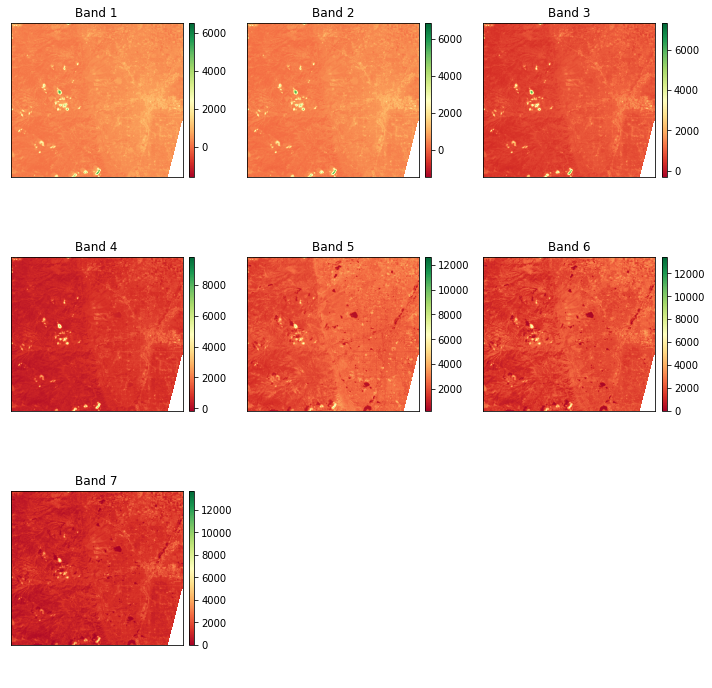

In [133]:
im = epp.plot_bands(arr_st, cmap='RdYlGn', figsize=(10,10))

## RGB Composite Image

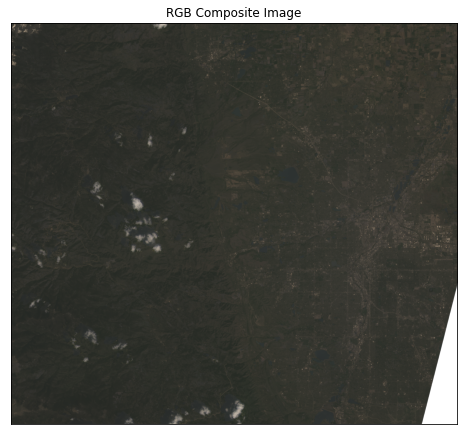

In [135]:
rgb = epp.plot_rgb(arr_st, rgb=(3,2,1), figsize=(8, 8), title='RGB Composite Image')

plt.show()

## Stretch Composite Image

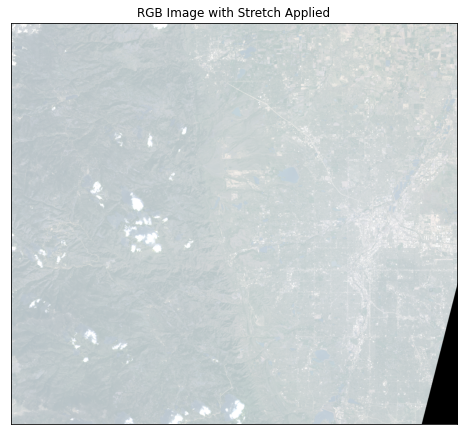

In [137]:
epp.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.8,
    figsize=(8,8),
    title="RGB Image with Stretch Applied",
)
plt.show()

## Histogram w.r.t Bands

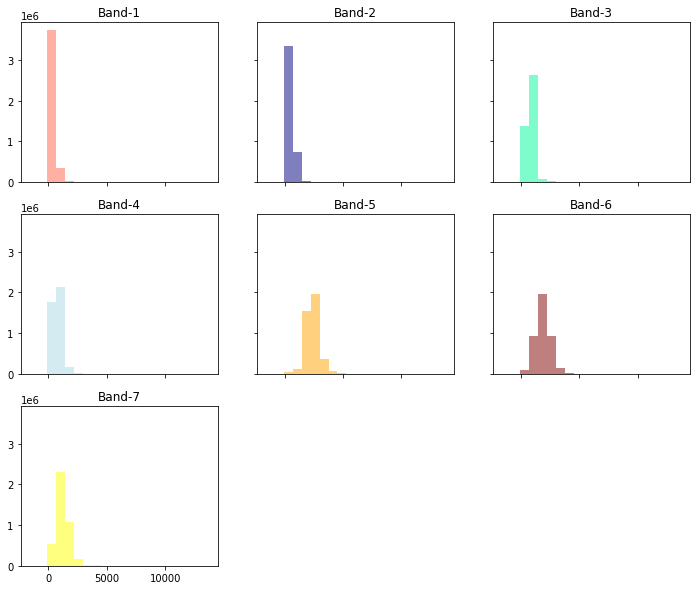

In [86]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'maroon', 'yellow']

epp.hist(arr_st, colors = colors, title=[f'Band-{i}' for i in range(1, 8)], cols=3, alpha=0.5, figsize = (12, 10), )

plt.show()

## Extraxt Spectral and plot

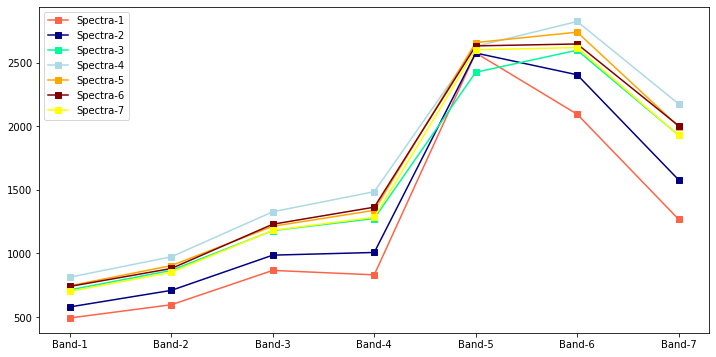

In [113]:
plt.figure(figsize=(12, 6))
for i, c in enumerate(colors):
  plt.plot(np.asarray(arr_st[:, 0, i]), '-s', color = c, label= f'Spectra-{i+1}')
plt.xticks(range(7),[f'Band-{i}' for i in range(1, 8)])
plt.legend()
plt.show()

## Calculating Normalized Difference Vegetation Index (NDVI)

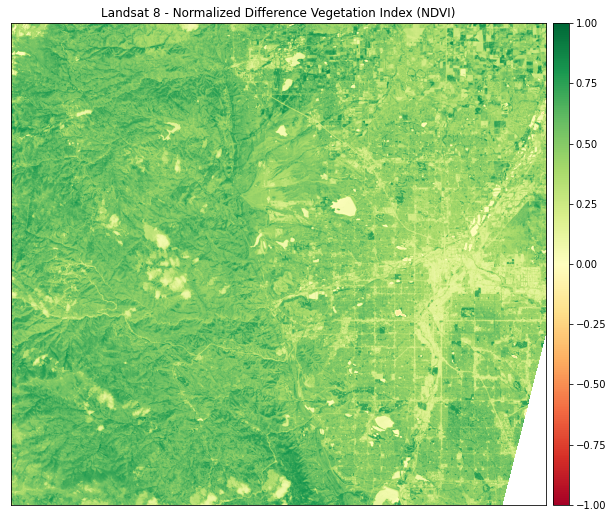

In [139]:
# Landsat 8 red band is band 4 at [3]
# Landsat 8 near-infrared band is band 5 at [4]

ndvi = es.normalized_diff(arr_st[4], arr_st[3])

titles = ["Landsat 8 - Normalized Difference Vegetation Index (NDVI)"]

epp.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=titles, vmin=-1, vmax=1, figsize=(10, 10))

plt.show()


## Classify NDVI

In [131]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.15, 0.23, 0.6, np.inf]


ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(np.ma.getmask(ndvi), ndvi_landsat_class)

np.unique(ndvi_landsat_class)

masked_array(data=[1, 2, 3, 4, 5, --],
             mask=[False, False, False, False, False,  True],
       fill_value=999999)

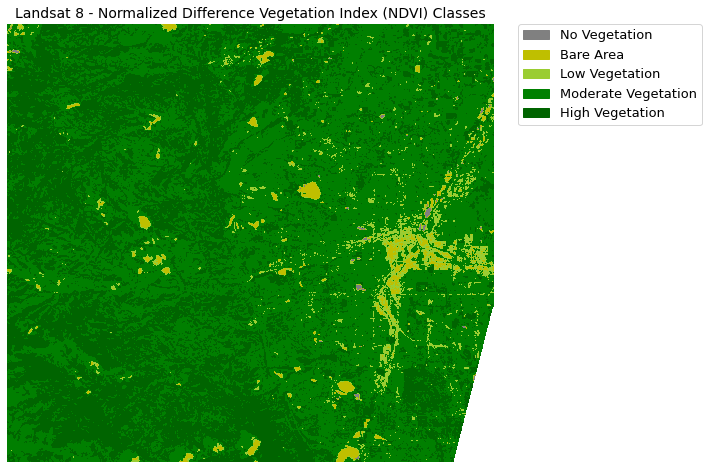

In [142]:
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
]

# Get list of classes
classes = np.unique(ndvi_landsat_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Plot your data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)

epp.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Landsat 8 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()